## Introduction

This notebook analyses the chances of survival of Titanic passengers, based on their **socio-economic status** (taking ticket class as a proxy), **gender**, **age**, and **port of embarkation**.  

The dataset we're using is named `titanic_data.csv` and its specifications are available [here](https://www.kaggle.com/c/titanic/data).  
Our base dataset will have the following columns:  
* `Pclass` - (ticket class)  
* `Sex` - (gender)  
* `Age` - (age)  
* `embarked` - (port of embarkation)  

Precisely, we will investigate the following questions:
- How does the ticket class impact the chances of survival?
- How does gender impact the chances of survival?
- How does age impact the chances of survival?
- How does the port of embarkation impact the chances of survival?

We will first reindex the DataFrame, clean the data if necessary, and identify possible `NaN` values. We will also remove outliers during an analysis if necessary.

We will also define two helper functions, `get_count` and `gen_plot`, that will prove helpful and save time all along the analysis.

## Preparing the dataset for analysis

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

df = pd.read_csv('data/titanic_data.csv')
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [2]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Our DataFrame `df` is indexed with the default method. Let's use the `PassengerId` as an index instead.

In [3]:
df = df.set_index(['PassengerId'])
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Let's also check `df` for missing values in the columns we're interested in, and let's then decide what to do with them.

In [4]:
def get_nan_count(column):
    '''
    column - the column for which we want the NaN value count.
    This function returns the number of NaN values in a specific column.
    '''
    nan_count = column.isnull().sum()
    return nan_count

In [5]:
get_nan_count(df['Survived'])

0

In [6]:
get_nan_count(df['Pclass'])

0

In [7]:
get_nan_count(df['Sex'])

0

In [8]:
get_nan_count(df['Age'])

177

In [9]:
get_nan_count(df['Embarked'])

2

Overall, our analysis will not have to deal with missing values for **Ticket Class** and **Sex**. We will ignore the missing values for the **Age** and **Embarked columns**.  
The **Age** column having 177 null values over 891 passengers, the results might be a little less reliable.

## Exploring and analyzing the data

Because we're looking at survival rates with 4 different factors, we should define a function that facilitates getting these rates.

In [10]:
survivor_count = df['Survived'].sum()

def get_survival_rate(dataframe, factor):
    '''
    df - the dataframe on which to apply the analysis
    factor - the factor / column for which we want the survival rate. Should be of type string.
    This function takes in a column and returns the survival rate of Titanic passengers according to this factor.
    '''
    by_factor = dataframe.groupby(factor)
    count_by_factor = by_factor['Survived'].sum()
    survival_rate = count_by_factor / survivor_count * 100
    print('Survival rates:', survival_rate, '\n \n', 'Counts: ', count_by_factor)
    return survival_rate, count_by_factor

## Correlation between survival and ticket class

First, let's see how socio-economic status, proxied with the ticket class, impacted survival.  
  
Before anything, we should get a rough idea of how the ticket classes were divided in the total of passengers.

In [11]:
total_passenger_count = len(df['Pclass'])
first_class_count = (df['Pclass'] == 1).sum()
second_class_count = (df['Pclass'] == 2).sum()
third_class_count = (df['Pclass'] == 3).sum()

per_first_class =  first_class_count / total_passenger_count * 100
per_second_class = second_class_count / total_passenger_count * 100
per_third_class = third_class_count / total_passenger_count * 100

In [12]:
print('First class percentage = ', per_first_class, ' | Count: ', first_class_count)
print('Second class percentage = ', per_second_class, ' | Count: ', second_class_count)
print('Third class percentage = ', per_third_class, ' | Count: ', third_class_count)

First class percentage =  24.2424242424  | Count:  216
Second class percentage =  20.6509539843  | Count:  184
Third class percentage =  55.1066217733  | Count:  491


We see that:  
* the **first class** represents **about a quarter** of the passengers on board (≈ 24%)  
* the **second class** represents **a little less than a quarter** of the passengers on board (≈ 20%)  
* the **third class** represents **more than half** of the passengers onboard (≈ 55%)

Let's now compare these percentages with the survival ones.

In [13]:
get_survival_rate(df, 'Pclass')

Survival rates: Pclass
1    39.766082
2    25.438596
3    34.795322
Name: Survived, dtype: float64 
 
 Counts:  Pclass
1    136
2     87
3    119
Name: Survived, dtype: int64


(Pclass
 1    39.766082
 2    25.438596
 3    34.795322
 Name: Survived, dtype: float64, Pclass
 1    136
 2     87
 3    119
 Name: Survived, dtype: int64)

With these survival rates, we can see that:
* **The first class** represents _≈ 24%_ of the passengers, but _≈ 40%_ of the survivors
* **The second class** represents _≈ 20%_ of the passengers, but _≈ 25%_ of the survivors
* **The third class** representes _≈ 55%_ of the passengers, but _≈ 34%_ of the survivors

Let's **visualize** these results to get a better understanding.  

Precisely, let's see how survival and death rates evolve according to ticket class, in **absolute count** and **percentage**.  

We're first going to define the function `get_counts` that allows us to get the precise count of deaths and survivals according to a specific quality. We will reuse this function throughout our analysis (except for our age anaysis).

In [14]:
def get_counts(dataframe, factor, quality, status):
    '''
    dataframe - the dataframe on which to apply the function (e.g. 'df' for the Titanic dataframe)
    factor - the column on which to perform the analysis (e.g. 'Pclass' for the ticket class)
    quality - the quality on which to perform the analysis (e.g '3' for the third class)
    status - the status you want to count: survival or death. Should be a Boolean (1 for survival, 0 for death).
    '''
    target = dataframe[factor].where(dataframe[factor] == quality)
    class_count = target.where(dataframe['Survived'] == status).count()
    return class_count

In [15]:
class1_survival_count = get_counts(df, 'Pclass', 1, 1)
class2_survival_count = get_counts(df, 'Pclass', 2, 1)
class3_survival_count = get_counts(df, 'Pclass', 3, 1)
class1_death_count = get_counts(df, 'Pclass', 1, 0)
class2_death_count = get_counts(df, 'Pclass', 2, 0)
class3_death_count = get_counts(df, 'Pclass', 3, 0)

In [16]:
print('SURVIVAL COUNT BY CLASS')
print('First class survival count:', class1_survival_count)
print('Second class survival count:', class2_survival_count)
print('Third class survival count:', class3_survival_count)
print('\nCASUALTIES COUNT BY CLASS')
print('First class death count:', class1_death_count)
print('Second class death count:', class2_death_count)
print('Third class death count:', class3_death_count)

SURVIVAL COUNT BY CLASS
First class survival count: 136
Second class survival count: 87
Third class survival count: 119

CASUALTIES COUNT BY CLASS
First class death count: 80
Second class death count: 97
Third class death count: 372


Now that we have our counts, we're ready to visualize the results. We're going to define our second helper function, `gen_plot`, which will generate two bar charts: one plotting **absolute counts** for the factor being analyzed, and the other plotting **percentages**.

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

def gen_plot(survival_array, death_array, by_factor, x_ticks):
    """
    survival_array: a list providing the survival data being analyzed (eg. [class1_survival_count, class2_survival_count, class3_survival_count])
    death_array: a list providing the death data being analyzed (eg. [class1_death_count, class2_death_count, class3_death_count])
    by_title: the factor that is the focus of the analysis (eg. 'by ticket class')
    x_ticks: (eg. ['First class', 'Second class', 'Third class'])
    """
    
    abs_survival_list = np.array(survival_array)
    abs_death_list = np.array(death_array)
    N = len(abs_survival_list)
    ind = np.arange(N)
    width = 1 / N

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))


    # Absolute count
    ax1.bar(ind, abs_survival_list, width, label='Survival', alpha=0.8)
    ax1.bar(ind, abs_death_list, width, color='#d62728', label='Death', alpha=0.8, bottom=abs_survival_list)

    plt.sca(ax1)
    plt.xticks(ind, x_ticks)

    ax1.set_title('Absolute count ' + by_factor)
    ax1.set_ylabel('Count')
    ax1.legend(loc='upper left')

    plt.setp(plt.gca().get_xticklabels(), rotation=45)


    # Percentage
    per_survival_list = (abs_survival_list / (abs_survival_list + abs_death_list)) * 100
    per_death_list = (abs_death_list / (abs_survival_list + abs_death_list)) * 100

    ax2.bar(ind, per_survival_list, width, label='Survival percentage', alpha=0.8)
    ax2.bar(ind, per_death_list, width, color='#d62728', label='Death percentage', alpha=0.8, bottom=per_survival_list)

    plt.sca(ax2)
    plt.xticks(ind, x_ticks)

    ax2.set_title('Percentage ' + by_factor)
    ax2.set_ylabel('Percentage')

    plt.setp(plt.gca().get_xticklabels(), rotation=45)

    return plt.show()

We can now plot the bar chart for our **ticket class** analysis.

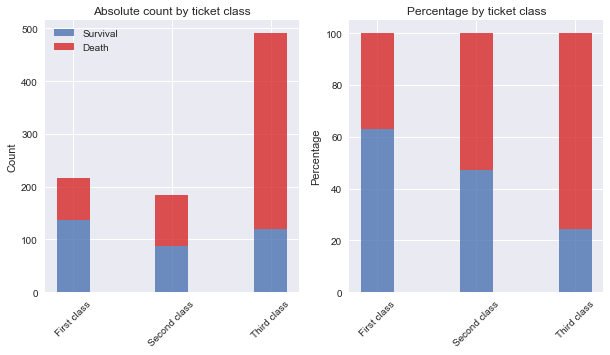

In [18]:
gen_plot([class1_survival_count, class2_survival_count, class3_survival_count],
         [class1_death_count, class2_death_count, class3_death_count],
         'by ticket class',
         ['First class', 'Second class', 'Third class'])

We can see that there is a clear correlation between death and ticket class: the higher your ticket class, the higher your chances of survival.

In [19]:
stats.chisquare(df['Survived'], df['Pclass'])

Power_divergenceResult(statistic=1592.1666666666665, pvalue=2.0399395484622444e-42)

## Correlation between survival and gender

Let's now analyze what impact gender had on chances or survival.
First, we're going to define a function similar to the one we used for ticket class, to get the count of survivals and deaths by gender.

In [20]:
female_survival_count = get_counts(df, 'Sex', 'female', 1)
male_survival_count = get_counts(df, 'Sex', 'male', 1)
female_death_count = get_counts(df, 'Sex', 'female', 0)
male_death_count = get_counts(df, 'Sex', 'male', 0)

In [21]:
print('SURVIVAL COUNT BY GENDER')
print('Female survival count: ', female_survival_count)
print('Male survival count: ', male_survival_count)
print('\nCASUALTIES COUNT BY GENDER')
print('Female death count: ', female_death_count)
print('Male death count: ', male_death_count)

SURVIVAL COUNT BY GENDER
Female survival count:  233
Male survival count:  109

CASUALTIES COUNT BY GENDER
Female death count:  81
Male death count:  468


Let's now visualize the data.

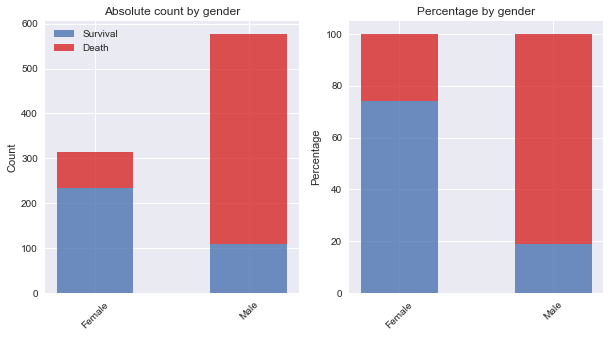

In [22]:
gen_plot([female_survival_count, male_survival_count],
         [female_death_count, male_death_count],
         'by gender',
         ['Female', 'Male'])

Let's put a number on this.  
First, we need to create a new DataFrame where we will replace non-int values: `female` will be 1 and `male` will be 0.

In [23]:
gender_df = df[['Sex', 'Survived']]
gender_df.replace(['male', 'female'], [0, 1], inplace=True)

gender_df[['Sex', 'Survived']].corr(method='pearson')

/Users/hadrien/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Sex,Survived
Sex,1.000000,0.543351
Survived,0.543351,1.000000


According to our analysis, there's a moderate correlation between survival and gender.

Let's pause here. We know that:
- women had a higher chance of survival than men
- first class passengers had a higher chance of survival than third class passengers

How do the chances of survival of a **first class woman** compare to those of a **third class man**?

In [24]:
df.groupby(['Sex', 'Pclass'])['Survived'].mean() * 100

Sex     Pclass
female  1         96.808511
        2         92.105263
        3         50.000000
male    1         36.885246
        2         15.740741
        3         13.544669
Name: Survived, dtype: float64

Chances of survival of a **first class woman**: ≈ 96.80%  
Chances of survival of a **third class man**: ≈ 13.54%  

This definitely explains how the movie ended...

## Correlation between survival and age

### Linear regression analysis

Now we're going to study the impact of age on chances of survival.  
We're going to look at the survival rates of children, compared to older people.  
Remember that we have 177 `NaN` (Not a Number) values here. In other words, we're going to have to cut our data by 20%. This is not ideal and you should always try to find a solution to save as many datum as possible, but in cases like this one we don't really have a choice.  

First, let's get rid of `NaN`
 values.

In [25]:
df_age = df[['Age' , 'Survived']].dropna(how='any')
df_age['Age'] = (np.floor(df_age['Age'])).astype(int)
df_age.shape

(714, 2)

In [26]:
df_age.head()

,Age,Survived
PassengerId,,
1,22,0
2,38,1
3,26,1
4,35,1
5,35,0


We counted **177** missing values.  
After deleting them, we get a new dataframe `df_age` with **714** rows.

In [27]:
print('Yougest passenger: ' + str(df_age['Age'].min() * 12) + ' months old')
print('\nOldest passenger: ' + str(df_age['Age'].max()) + ' years old')

Yougest passenger: 0 months old

Oldest passenger: 80 years old


We rounded the ages up for the sake of this analysis, so the youngest passenger on board was a few months old, and the oldest was 80 years old.  
Now let' order our data and create a new DataFrame `df_ages_survival`. It will `Age` indexed. Four each age, 4 columns will give us the following information:
- Number of passengers of index age that survived
- Number of passengers of index age that died
- Total number of passengers of index age
- Percentage of survivors of that index age

In [28]:
ages_list = df_age['Age'].unique()
ages_list.sort()
ages_list

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 70,
       71, 74, 80])

In [29]:
df_ages_survival = pd.DataFrame(index=ages_list, columns=['Survived', 'Deaths', 'Total', 'Percentage'])

df_ages_survival['Survived'] = df_age.groupby('Age')['Survived'].sum()
df_ages_survival['Total'] = df_age.groupby('Age').count()
df_ages_survival['Deaths'] = df_ages_survival['Total'] - df_ages_survival['Survived']
df_ages_survival['Percentage'] = round(df_age.groupby('Age')['Survived'].mean() * 100, 2)

# for age in ages_list:
#     df_ages_survival.loc[age]['Survived'] = (df_age['Age'] == age).where(df_age['Survived'] == 1).sum()
#     df_ages_survival.loc[age]['Total'] = (df_age['Age'] == age).sum()
#     df_ages_survival.loc[age]['Deaths'] = df_ages_survival.loc[age]['Total'] - df_ages_survival.loc[age]['Survived']
#     df_ages_survival.loc[age]['Percentage'] = (df_ages_survival.loc[age]['Survived'] / df_ages_survival.loc[age]['Total']) * 100
#     
# df_ages_survival.head()

df_ages_survival.head()

,Survived,Deaths,Total,Percentage
0,7,0,7,100.00
1,5,2,7,71.43
2,3,7,10,30.00
3,5,1,6,83.33
4,7,3,10,70.00


Let's take a look at a scatter plot of our data, and see if we can identify any outliers.

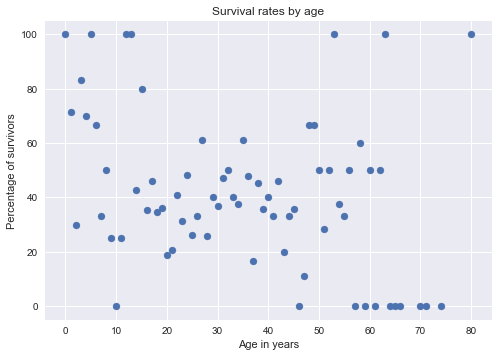

In [30]:
x = df_ages_survival['Percentage'].index
y = df_ages_survival['Percentage']
plt.scatter(x, y)
m, b = np.polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.title('Survival rates by age')
plt.xlabel('Age in years')
plt.ylabel('Percentage of survivors')
plt.show()

We can identify a tendency where the lower y values have high x coordinates, and high y values have low x coordinates. This means that apparently, the younger you are, the more chances you have to survive.  

However, there are three dots on the upper right side of the graph that seem to be outliers. They are not representative of the general tendency: let's identify them, remove them from the DataFrame, plot it again and fit a regression line.

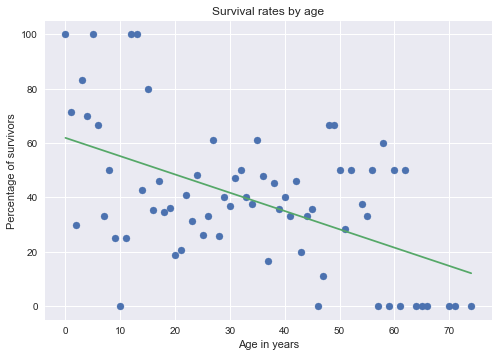

In [31]:
df_ages_survival = df_ages_survival.drop(df_ages_survival[(df_ages_survival['Percentage'] == 100) & (df_ages_survival.index > 50)].index)
x = df_ages_survival['Percentage'].index
y = df_ages_survival['Percentage']
plt.scatter(x, y)
m, b = np.polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, m*x + b, '-')
plt.title('Survival rates by age')
plt.xlabel('Age in years')
plt.ylabel('Percentage of survivors')
plt.show()

The regression line clearly shows that the younger you were, the higher your chances to survive. Let's get information about the regression line (especially the slope):

In [32]:
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

print('Slope: ', slope)
print('Intercept: ', intercept)
print('r_value: ', r_value)
print('r_squared: ', r_value ** 2)
print('p_value: ', p_value)
print('std_error: ', std_err)

Slope:  -0.673144857521
Intercept:  61.9383032482
r_value:  -0.527964394447
r_squared:  0.278746401804
p_value:  3.711919882e-06
std_error:  0.133283357989


Now this is enough to get some insight, but maybe there's a better way to visualize the data. Let's plot a kernel density estimate of ages according to survival status:

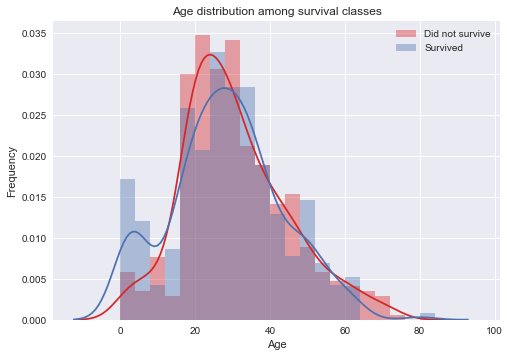

In [33]:
age_bins = np.arange(0, 100, 4)
sns.distplot(df.loc[(df['Survived']==0) & (~df['Age'].isnull()),'Age'], bins=age_bins, color='#d62728')
sns.distplot(df.loc[(df['Survived']==1) & (~df['Age'].isnull()),'Age'], bins=age_bins)
plt.title('Age distribution among survival classes')
plt.ylabel('Frequency')
plt.legend(['Did not survive', 'Survived'])
plt.show()

We can definitely see a spike in the distribution of survival passengers when the age is small, indicating children had a higher survival rate.

### Specific age analysis

We're going to carry on and strengthen our analysis by bringing more light on two specific ages, so that we also have a benchmark. We will use a bar chart.

We will analyze ages 6 and 12, but you can change the `age` argument in the function we're going to define with the age of your choice.  

Below is a new function similar to `get_counts`. It will fit the `inferior or equal` condition of our analysis and return the survival and death counts for both configurations, taking a user defined `age` as an argument.

In [34]:
def get_age_counts(age):
    '''
    age - the age limit on which to apply the analysis
    This function returns, in order, the survival count for people under or equal to the age specified and people older than the age specified,
    and the death count people under or equal to the age specified and people older than the age specified.
    '''
    younger_target = df['Age'].where(df['Age'] <= age)
    older_target = df['Age'].where(df['Age'] > age)
    younger_survival_count = younger_target.where(df['Survived'] == 1).count()
    older_survival_count = older_target.where(df['Survived'] == 1).count()
    younger_death_count = younger_target.where(df['Survived'] == 0).count()
    older_death_count = older_target.where(df['Survived'] == 0).count()
    return younger_survival_count, older_survival_count, younger_death_count, older_death_count

In [35]:
up_to_6_survival_count, over_6_survival_count, up_to_6_death_count, over_6_death_count = get_age_counts(6)
up_to_12_survival_count, over_12_survival_count, up_to_12_death_count, over_12_death_count = get_age_counts(12)

print('AGE LIMIT = 6')
print('Survival count for children up to 6: ', up_to_6_survival_count)
print('Survival count for people over 6: ', over_6_survival_count)
print('Death count for children up to 6: ', up_to_6_death_count)
print('Death count for people over 6: ', over_6_death_count)

print('\nAGE LIMIT = 12')
print('Survival count for children up to 12: ', up_to_12_survival_count)
print('Survival count for people over 12: ', over_12_survival_count)
print('Death count for children up to 12: ', up_to_12_death_count)
print('Death count for people over 12: ', over_12_death_count)

AGE LIMIT = 6
Survival count for children up to 6:  33
Survival count for people over 6:  257
Death count for children up to 6:  14
Death count for people over 6:  410

AGE LIMIT = 12
Survival count for children up to 12:  40
Survival count for people over 12:  250
Death count for children up to 12:  29
Death count for people over 12:  395


Now we're ready to build our bar charts.
Looking at the graphs, our _over 6_ and _over 12_ counts and percentages will probably look identical.


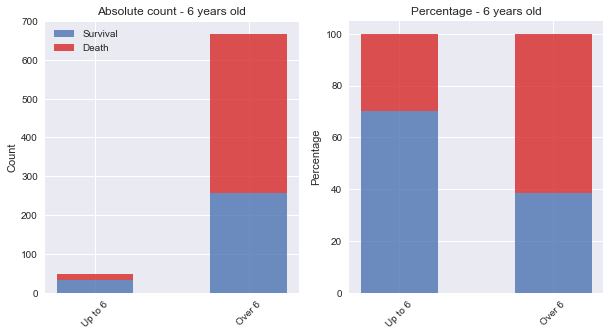

In [36]:
# Plot for age 6
gen_plot([up_to_6_survival_count, over_6_survival_count],
         [up_to_6_death_count, over_6_death_count],
         '- 6 years old',
         ['Up to 6', 'Over 6'])

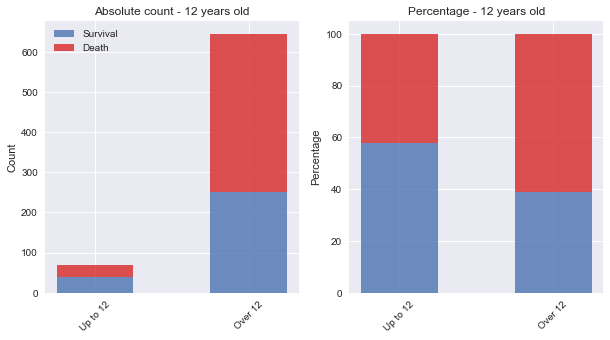

In [37]:
# Plot for age 12
gen_plot([up_to_12_survival_count, over_12_survival_count],
         [up_to_12_death_count, over_12_death_count],
         '- 12 years old',
         ['Up to 12', 'Over 12'])

It would seem that children up to 6 years old had a higher chance of survival than people over 6 years old.  
It would also seem that children up to 12 years old had a higher chance of survival than people over 12 years old, but lower than people up to 6 years old.

This comforts our first hypothesis: the younger you were, the higher your chances to survive.

## Correlation between survival and port of embarkation

Our final analysis will look at chances of survival based on the port of embarkation.  
Titanic passengers embarked form three different ports:
- Cherbourg (C)
- Queenstown (Q)
- Southampton (S)

Before anything, we should get a rough idea of how the ticket classes were divided in the total of passengers.

In [38]:
total_passenger_count = len(df['Embarked'])
cherbourg_count = (df['Embarked'] == 'C').sum()
queenstown_count = (df['Embarked'] == 'Q').sum()
southampton_count = (df['Embarked'] == 'S').sum()

per_cherbourg =  cherbourg_count / total_passenger_count * 100
per_queenstown = queenstown_count / total_passenger_count * 100
per_southampton = southampton_count / total_passenger_count * 100

In [39]:
print('Cherbourg percentage = ', per_cherbourg, ' | Count: ', cherbourg_count)
print('Queenstown percentage = ', per_queenstown, ' | Count: ', queenstown_count)
print('Southampton percentage = ', per_southampton, ' | Count: ', southampton_count)

Cherbourg percentage =  18.8552188552  | Count:  168
Queenstown percentage =  8.64197530864  | Count:  77
Southampton percentage =  72.278338945  | Count:  644


We see that:  
* ≈ 19% of the passengers embarked from Cherbourg
* ≈ 9% of the passengers embarked from Queenstown
* ≈ 72% of the passengers embarked from Southampton

In [40]:
get_survival_rate(df, 'Embarked')

Survival rates: Embarked
C    27.192982
Q     8.771930
S    63.450292
Name: Survived, dtype: float64 
 
 Counts:  Embarked
C     93
Q     30
S    217
Name: Survived, dtype: int64


(Embarked
 C    27.192982
 Q     8.771930
 S    63.450292
 Name: Survived, dtype: float64, Embarked
 C     93
 Q     30
 S    217
 Name: Survived, dtype: int64)

With these survival rates, we can see that:
* Passengers from Cherbourg made up about 19% of the headcount, but about 27% of the survivors
* Passengers from Queenstown made up about 9% of the headcount, and about 9% of the survivors
* Passengers from Southampton made up about 72% of the headcount, and about 63% of the survivors

Let's **visualize** these results to get a better understanding.  
Precisely, let's see how survival and death rates evolve according to port of embarkation, in **absolute count** and **percentage**. We'll use the `get_counts` function once more.

In [41]:
cherbourg_survival_count = get_counts(df, 'Embarked', 'C', 1)
queenstown_survival_count = get_counts(df, 'Embarked', 'Q', 1)
southampton_survival_count = get_counts(df, 'Embarked', 'S', 1)
cherbourg_death_count = get_counts(df, 'Embarked', 'C', 0)
queenstown_death_count = get_counts(df, 'Embarked', 'Q', 0)
southampton_death_count = get_counts(df, 'Embarked', 'S', 0)

In [42]:
print('SURVIVAL COUNT BY PORT OF EMBARKATION')
print('Cherbourg survival count:', cherbourg_survival_count)
print('Queenstown class survival count:', queenstown_survival_count)
print('Southampton survival count:', southampton_survival_count)
print('\nCASUALTIES COUNT BY PORT OF EMBARKATION')
print('Cherbourg death count:', cherbourg_death_count)
print('Queenstown death count:', queenstown_death_count)
print('Southampton death count:', southampton_death_count)

SURVIVAL COUNT BY PORT OF EMBARKATION
Cherbourg survival count: 93
Queenstown class survival count: 30
Southampton survival count: 217

CASUALTIES COUNT BY PORT OF EMBARKATION
Cherbourg death count: 75
Queenstown death count: 47
Southampton death count: 427


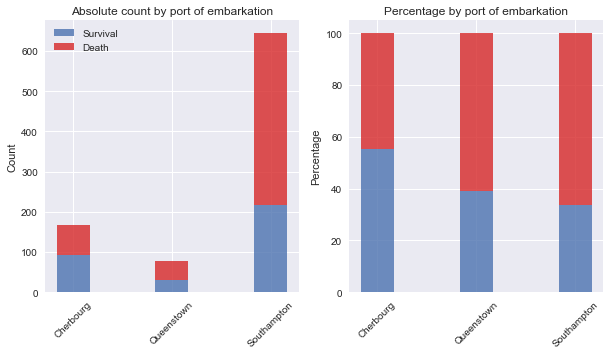

In [43]:
gen_plot([cherbourg_survival_count, queenstown_survival_count, southampton_survival_count],
         [cherbourg_death_count, queenstown_death_count, southampton_death_count],
         'by port of embarkation',
         ['Cherbourg', 'Queenstown', 'Southampton'])

I don't suppose women and children were over represented in either port of embarkation. We can make two hypotheses then:
* Passengers from Cherbourg tended to have higher class tickets, and passengers from Southampton lower class tickets
* Passengers from Southampton had cabins located closer to the impact, or further from the deck  

We can test the first hypothesis (class distribution).

In [44]:
# Cherbourg distribution per class
cherbourg_df = df[df['Embarked'] == 'C']
southampton_df = df[df['Embarked'] == 'S']

count_cherbourg_first = (cherbourg_df['Pclass'] == 1).sum()
count_cherbourg_second = (cherbourg_df['Pclass'] == 2).sum()
count_cherbourg_third = (cherbourg_df['Pclass'] == 3).sum()

per_cherbourg_first = count_cherbourg_first / cherbourg_count * 100
per_cherbourg_second = count_cherbourg_second / cherbourg_count * 100
per_cherbourg_third = count_cherbourg_third / cherbourg_count * 100


# Southampton distribution per class
count_southampton_first = (southampton_df['Pclass'] == 1).sum()
count_southampton_second = (southampton_df['Pclass'] == 2).sum()
count_southampton_third = (southampton_df['Pclass'] == 3).sum()

per_southampton_first = count_southampton_first / southampton_count * 100
per_southampton_second = count_southampton_second / southampton_count * 100
per_southampton_third = count_southampton_third / southampton_count * 100

In [45]:
print('Cherbourg first class percentage = ', per_cherbourg_first)
print('Cherbourg second class percentage = ', per_cherbourg_second)
print('Cherbourg third class percentage = ', per_cherbourg_third)

print('\nSouthampton first class percentage = ', per_southampton_first)
print('Southampton second class percentage = ', per_southampton_second)
print('Southampton third class percentage = ', per_southampton_third)

Cherbourg first class percentage =  50.5952380952
Cherbourg second class percentage =  10.119047619
Cherbourg third class percentage =  39.2857142857

Southampton first class percentage =  19.7204968944
Southampton second class percentage =  25.4658385093
Southampton third class percentage =  54.8136645963


It looks like our first hypothesis was right:
- about 50% of the passengers from Cherbourg were first class
- about 55% of the passengers from Southampton were second class  

This explains why the survival rate is higher for Cherbourg passengers than from Southampton passengers.

Let's reiterate the combined analysis (gender and ticket class) we did previously, adding the port of embarkation factor in the equation.

In [46]:
df.groupby(['Sex', 'Pclass', 'Embarked'])['Survived'].mean() * 100

Sex     Pclass  Embarked
female  1       C            97.674419
                Q           100.000000
                S            95.833333
        2       C           100.000000
                Q           100.000000
                S            91.044776
        3       C            65.217391
                Q            72.727273
                S            37.500000
male    1       C            40.476190
                Q             0.000000
                S            35.443038
        2       C            20.000000
                Q             0.000000
                S            15.463918
        3       C            23.255814
                Q             7.692308
                S            12.830189
Name: Survived, dtype: float64

Chances of survival of a **first class woman from Cherbourg**: ≈ 97.67%  
Chances of survival of a **third class man from Southampton**: ≈ 12.83%  

## Conclusion

From this analysis, we would be inclined to conclude that passengers had higher chances of survival if:
- they had a high class ticket
- they were women
- they were young
- they embarked from Cherbourg

On the contrary, being a third class old man from Southampton lowered your chances of survival.  

However, there are a few things we should keep in mind:
- this dataset contains data about 891 passengers, but there were 2228 passengers in total. We only have a little more than a third of the data.
- there is missing data, especially on the age analysis.
- we could have other information about the passengers, such as how close to a lifeboat they were. This might have had an impact as well.